# Homework 10

## Problem 1. 30 POINTS
Create a bash shell script that will create a sqlite database of the 4 csv files in this directory. Make sure that you assing meaningful data types and constraints to your database.

In [3]:
#!/bin/bash

sqlite3 table_four.db <<EOF

CREATE TABLE encounter(
  "encounterid" TEXT PRIMARY KEY NOT NULL UNIQUE,
  "patientid" TEXT NOT NULL,
  "encounterdate" TEXT NOT NULL, 
  "encounterphysician" TEXT NOT NULL,
  "encounterreason" TEXT NOT NULL,
  "billingamount" REAL NOT NULL
);

CREATE TABLE physician(
  "physicianid" TEXT PRIMARY KEY NOT NULL UNIQUE,
  "lastname" TEXT NOT NULL,
  "firstname" TEXT NOT NULL, 
  "specialty" TEXT NOT NULL
);

CREATE TABLE billing(
  "billingid" TEXT PRIMARY KEY NOT NULL UNIQUE,
  "encounterid" TEXT NOT NULL,
  "code" TEXT NOT NULL
);

CREATE TABLE patient(
  "patientid" TEXT PRIMARY KEY NOT NULL UNIQUE,
  "lastname" TEXT NOT NULL,
  "firstname" TEXT NOT NULL, 
  "gender" TEXT NOT NULL,
  "dob" TEXT NOT NULL
);

.mode csv

.import ./encounter.csv encounter
.import ./physician.csv physician 
.import ./billing.csv billing
.import ./patient.csv patient

.schema encounter
.schema physician
.schema billing
.schema patient


EOF


/Users/shengyuli/Desktop/BIOS-821/Homework/home_work/homework10


## Problem 2. 30 POINTS.
Using python, answer the following questions:
    1. Provide code that creates a pandas dataframe that contains a patient-level dataset with:
        - LastName
        - FirstName
        - Total Billing Amount
    2. The billing department needs to modify each billing statment so that we take the total billing amount for each person, multiply it by 4.2 and subtract 10. Create a new column on your pandas dataframe that applies this correction and name this variable `correction`.
    3. For all patients less than 40 years old, create a pandas data frame that contains:
        - LastName
        - FirstName
        - physician last name
        - physician first name
        - total times seen that physician
    

In [19]:
"""1"""
from sqlalchemy import create_engine
import pandas as pd
engine = create_engine('sqlite:///table_four.db')
df_encounter = pd.read_sql('select * from encounter;', engine)
df_patient = pd.read_sql('select * from patient', engine)

#Drop the first redundent column name and columns in the both dataframes
df_encounter = df_encounter.drop([0])
df_patient = df_patient.drop([0])
df_patient = df_patient.drop(columns=["gender","dob"])

#Find the sum of billing amount for each patient
dfsum = df_encounter.groupby(['patientid'])[["billingamount"]].sum()
dfsum = dfsum.reset_index()

#Merge two dataframes together
df1 = df_patient.set_index('patientid').join(dfsum.set_index('patientid'))
df1 = df1.fillna(0)
df1


,lastname,firstname,billingamount
patientid,,,
1,doe,john,186.97
2,doe,jane,0.00
3,sickly,joseph,888.10
4,well,sally,0.00
5,daily,bob,375.69


In [572]:
"""2"""
#Do the calculation and set it to new column
df1['correction'] = df1['billingamount']*4.2-10

#There are two patients with negative correction, which is impossible. Thus, set negative value to zero
df1.loc[df1['correction'] < 0, 'correction'] = 0

df1


,lastname,firstname,billingamount,correction
patientid,,,,
1,doe,john,186.97,775.274
2,doe,jane,0.00,0.000
3,sickly,joseph,888.10,3720.020
4,well,sally,0.00,0.000
5,daily,bob,375.69,1567.898


In [573]:
"""3"""
import datetime as DT

#Make a list of patient with date of birth and last name first name only
df_patient2 = pd.read_sql('select * from patient', engine)
df_patient2 = df_patient2.drop(columns=['gender']).drop([0])
df_patient2 = df_patient2.set_index('patientid')
df_patient2


#Change dob to age
df_patient2.astype('str')
df_patient2['dob'] = df_patient2['dob'].str[-2:]
df_patient2['dob'] = df_patient2['dob'].astype('int')
df_patient2['age'] = (DT.datetime.now().year-2000+100) - df_patient2['dob']
df_patient2 = df_patient2.drop(columns=['dob'])

#Select patients age less or equal to 40
df_patient2 = df_patient2.loc[df_patient2['age'] < 40]


#subset a physician dataframe with only last name and first name
df_physician = pd.read_sql('select * from physician', engine)
df_physician = df_physician.drop([0])
df_physician = df_physician.drop(columns=['specialty'])
df_physician

#Merge the physician dataframe and the encounter dataframe 
df_encounter = df_encounter.rename(columns={'encounterphysician': 'physicianid'})
df_encounter2 = pd.merge(df_encounter, df_physician, on = 'physicianid', how = 'outer')
df_encounter2

#Merge the patients' information with phyicians' information and drop redundent columns
df_final = pd.merge(df_patient2,df_encounter2, on = 'patientid', how = 'left')
df_final = df_final.drop(columns= ['age', 'encounterid', 'encounterreason','billingamount','encounterdate'])
df_final = df_final.fillna('No Record')

#Count the times each patients see that physicians 
df_final = df_final.groupby(['patientid','physicianid', 'lastname_x','firstname_x','lastname_y','firstname_y']).size().reset_index()
df_final = df_final.drop(columns=['patientid','physicianid'])

df_final.columns=['LastName','FirstName','physician last name','physician first name','total times seen that physician']

#There is one patient who had not seen any physician, set it to 'No Record'
df_final.loc[df_final['physician first name'] == 'No Record', 'total times seen that physician'] = 'No Record' 
df_final




,LastName,FirstName,physician last name,physician first name,total times seen that physician
0,sickly,joseph,whitecoat,bill,1
1,sickly,joseph,na,li,3
2,sickly,joseph,wei,liu,2
3,well,sally,No Record,No Record,No Record
4,daily,bob,satterwhite,jill,1
5,daily,bob,na,li,1


## Problem 1. 15 POINTS
You should have received an email that contains:
    - host
    - user
    - password
    
Go ahead and create three environment variables that hold this information. From this point forward, if you need this information, you should refer to the environment variables and NOT the values themselves. You will lose all points, if the values themselves are in the code and submitted to github. You will have effectively disclosed very sensitive data. **NOTE**, there is no code you turn in to get points for this problem. Rather, I will know that you have done this by reviewing the code below.

## Problem 2. 5 POINTS
Create a `sqlalchemy` engine that is connected to our database. **NOTE** use the environment variables set up in problem 1 to do this. There should be NO host, username, or passwords visible if you are using environment variables correctly. You may receive some `ImportError`. You will need to figure out how to resolve these issues.

In [2]:
import os 
from sqlalchemy import create_engine
enginexx = create_engine('postgresql://'+os.getenv('user')+':'+os.getenv('password')+'@'+os.getenv('host'))



TypeError: can only concatenate str (not "NoneType") to str

## Problem 3. 20 POINTS
Using the engine created in Problem 2. Use sqlalchemy to help you create a hand drawn ER diagram. Please find a way to get you hand-drawn ER diagram into this repository. HINT, if you take a picture with your phone, you can use that image (which is just a file) to put into this directory.

In [1]:
from sqlalchemy import MetaData

m = MetaData()
m.reflect(enginexx)

for table in m.tables.values():
    print('*************************')
    print('TABLE: ' + table.name)
    print('COLUMNS:')
    for column in table.c:
        print('\t' + column.name)
        
#from eralchemy import render_er
#render_er('postgresql://'+os.getenv('user')+':'+os.getenv('password')+'@'+os.getenv('host'), 'ER.png')

NameError: name 'enginexx' is not defined

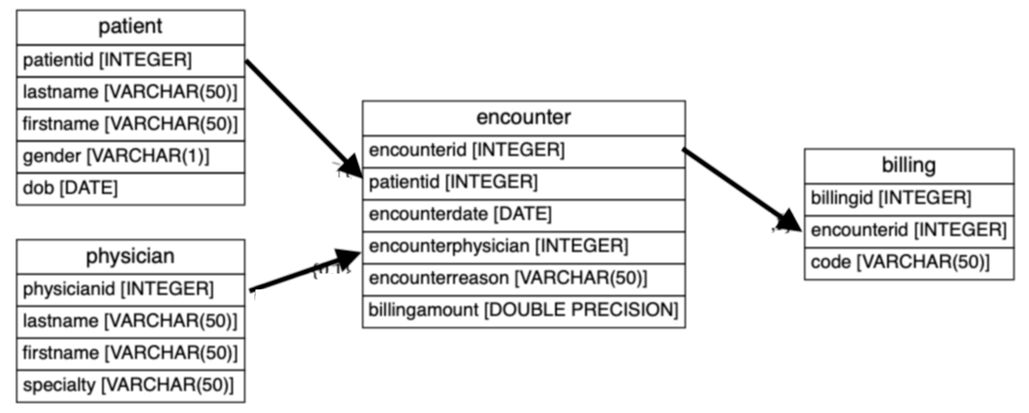

In [7]:
from IPython.display import Image
PATH = "/Users/shengyuli/Desktop/BIOS-821/Homework/home_work/homework10/"
Image(filename = PATH + "ER.png", width=1000, height=500)